# Coronavirus Cases in Finland

##### __Bernardo Di Chiara__

_Last update: March 16<sup>th</sup>, 2020_

Last plotted day: March 14<sup>th</sup>, 2020

## Table of Contents

[1. Executive Summary](#1.)<br>
[2. Setup](#2.)<br>
[3. Defining the Needed Functions](#3.)<br>
<font color='white'>....</font>[3.1. Dataframes and lists handling](#3.1.)<br>
<font color='white'>....</font>[3.2. Scatter and line plots](#3.2.)<br>
<font color='white'>....</font>[3.3. Project-specific functions](#3.3.)<br>
[4. Dumping the Data](#4.)<br>
[5. Data Analysis](#5.)<br>
<font color='white'>....</font>[5.1. Summary](#5.1.)<br>
<font color='white'>....</font>[5.2. Preliminary Data Analysis](#5.2.)<br>
<font color='white'>....</font>[5.3. Data Preparation](#5.3.)<br>
<font color='white'>............</font>[5.3.1. Finnish Data from JHU](#5.3.1.)<br>
<font color='white'>............</font>[5.3.2. Finnish Data: Calculating the increments](#5.3.2.)<br>
<font color='white'>............</font>[5.3.3. Data from other Scandinavian Countries](#5.3.3.)<br>
<font color='white'>............</font>[5.3.4. Data from Italy](#5.3.4.)<br>
<font color='white'>............</font>[5.3.5. Data from China](#5.3.5.)<br>
[6. Data Visualization](#6.)<br>
<font color='white'>....</font>[6.1. Finnish Internal Situation](#6.1.)<br>
<font color='white'>....</font>[6.2. Comparison with Other Scandinavian Countries](#6.2.)<br>
<font color='white'>....</font>[6.3. Comparison with Italy and China](#6.3.)<br>
[7. Conclusions](#6.)<br>

## 1. Executive Summary <a name="1."></a>

This notebook contains visualizations related to the spread of Coronavirus in Finland.

The data is taken from the [Johns Hokpins University](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset/data) (JHU) /1/.

There are a lot of pages related to this topic in the Web but currently there is no free site that shows plots of the daily cases in Finland with a delay of less than 24 hours. Also, it migth be beneficial to compare Finnish curves with curves from other Countries.

Having updated charts is very useful both for authorities and population in order to make fact-based decisions that help to contain the cases and minimize the casualities.

Comparing to what is happening / has happened to other Countries can help in decision making.

A line plot containing confirmed cases each day as well as recovered cases and deceased cases in Finland has been produced.

A second line plot containing the new confirmed daily cases in Finland, which shows the speed at which the virus is spreading, has been added.

Finally, Finnish curves have been compared to the curves of other Scandinavian Countries as well as to the curves of the two Countries which have had the most critical situation so far: China and Italy.

<sub>/1/<br>
https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset/data</sub>

**If you are not interested to the code, go to section 6 through the link in the table of contents and ignore the code.**

**DISCLAIMER:**
    
- The code has not been peer-reviewed. If someone is wishing to do it, please contact the author.
- The data related to the last day might be incomplete.

## 2. Setup <a name="2."></a>

In [1]:
# Importing the needed packages
import regex as re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Displaying all the dafaframe columns
pd.set_option('display.max_columns', None)

## 3. Defining the Needed Functions <a name="3."></a>

### 3.1. Dataframe handling<a name="3.1."></a>

In [2]:
def df_basic_data(dfname):
    '''
    This function prints basic information about a given dataframe.
    The function needs as input parameters the dataframe name.
    '''

    import pandas as pd

    # Fetching the dataframe name
    name = [x for x in globals() if globals()[x] is dfname][0]
    print("Dataframe name:", name, "\n")
    print("Dataframe length:", len(dfname), "\n")
    print("Number of columns:", len(dfname.columns), "\n")
    # Columns data types
    data_types = dfname.dtypes
    # Distint values
    distint_values = dfname.apply(pd.Series.nunique)
    # Amount of null values
    null_values = dfname.isnull().sum()
    print("Dataframe's columns names, column data types, amount of distint "
          "(non null) values\n"
          "and amount of null values for each column:")
    df_index = ['Data_Type',
                'Amount_of_Distint_Values',
                'Amount_of_Null_Values']
    col_types_dist_null = pd.DataFrame([data_types,
                                        distint_values,
                                        null_values],
                                       index=df_index)
    return col_types_dist_null.transpose()

In [3]:
def calc_increments(listname):
    '''
    This function:
    takes a list,
    calculates the delta between each element and its predecessor,
    returns the result in a new list having the same lenght as the original list
    '''

    # Initializing an empty list of floats to contain the increments
    increments = []
    # Adding zero to the first element
    increments.append(0.0)
    # Looping through all the occurrencies except the first one
    for i in list(range(1, len(listname))):
        # Calculating the increment
        delta = listname[i]-listname[i-1]
        # Adding the result to the list
        increments.append(delta)
    # Returning the result
    return increments

### 3.2. Scatter and line plots<a name="3.2."></a>

In [4]:
def cust_line_plot(*parameters,
                   figsize_w=8, figsize_h=6,
                   title=None, title_fs=16, title_offset=20,
                   rem_borders=False,
                   x_label=None, xlabel_fs=12,
                   xvalues_fs=6, rot=0,
                   y_label=None, ylabel_fs=12,
                   legend=False):
    """
    This function plots a scatterplot for the provided data
    and customizes the way the chart looks by using the value of
    the provided parameters.

    Keyword arguments:
    parameters       -- A tuple of 5 elements containing:
                        a list with the x values,
                        a list with the y values,
                        a string containing the selected marker,
                        an integer (from 0 to 9) selecting the seaborn-deep
                        color,
                        a string containing the text for the legend
                        (mandatory)
    x                -- A list Series containing the x values (mandatory)
    figsize_w        -- The width of the plot area
    figsize_w        -- The height of the plot area
    title            -- A string containing the title of the chart
    title_fs         -- The title font size
    title_offset     -- Distance between the title and the top of the chart
    rem_borders      -- If True the top and right borders are removed
                        (default: False)
    x_label          -- Label for the x-axis (string)
    xlabel_fs        -- x axis labels' font size
    xvalues_fs       -- The tick values font size
    rot              -- The rotation angle of the tick values
    y_label          -- Label for the y-axis (string)
    ylabel_fs        -- y axis labels' font size
    legend           -- A boolean variable that tells if to plot a legend
    """

    import matplotlib.pyplot as plt
    import seaborn as sns

    # Creating a new figure
    plt.figure(figsize=(figsize_w, figsize_h))
    # Defining the used style
    color_list = sns.color_palette(palette='deep')
    # Adding a title (with some distance to the top of the plot)
    plt.title(title, fontsize=title_fs, pad=title_offset)
    # Removing the top and right borders if so defined
    if rem_borders is True:
        sns.despine(top=True, right=True, left=False, bottom=False)

    # Initializing an empy list to contain the legend text
    leg_text_l = []
    for param in parameters:
        # Extracting the values given in parameters
        x = param[0]
        y = param[1]
        mark = param[2]
        col_numb = param[3]
        leg_text = param[4]
        # Appending the string to the list
        leg_text_l.append(leg_text)
        # Creating the scatter plots
        plot = plt.plot(x, y, marker=mark, color=color_list[col_numb])

    # If a label for the x axis is provided, showing it on the x axis
    if x_label:
        plt.xlabel(x_label, fontsize=xlabel_fs)
    plt.xticks(fontsize=xvalues_fs, rotation=rot)
    # If a label for the y axis is provided, showing it on the y axis
    if y_label:
        plt.ylabel(y_label, fontsize=ylabel_fs)

    # Adding a legend
    if legend:
        plt.legend(labels=leg_text_l)

    # Showing the plot without additional text
    plt.show()

### 3.3. Project-specific functions<a name="3.3."></a>

In [5]:
def extract_country(country):
    '''
    This function allows selecting data related to a specific Country
    from the datasets produced by JHU.
    It takes as an input a string containing the Country name.
    It returns a tuple of 3 lists containing data related to confirmed,
    recovered and deceased cases startinng from January 28th.
    '''

    # Extracting confirmed cases
    confirm = world_confirmed[world_confirmed['Country/Region'] == country]
    # Extracting the columns containing the data for each day
    # starting from the first day of interest for Finland (January 28th)
    confirm = confirm.iloc[:, 10:]
    # Copying the result into a list
    confirm_l = confirm.values.tolist()[0]

    # Extracting recovered cases
    recov = world_recovered[world_recovered['Country/Region'] == country]
    # Extracting the columns containing the data for each day
    # starting from the first day of interest for Finland (January 28th)
    recov = recov.iloc[:, 10:]
    # Copying the result into a list
    recov_l = recov.values.tolist()[0]

    # Extracting deceased cases
    deceas = world_deaths[world_deaths['Country/Region'] == country]
    # Extracting the columns containing the data for each day
    # starting from the first day of interest for Finland (January 28th)
    deceas = deceas.iloc[:, 10:]
    # Copying the result into a list
    deceas_l = deceas.values.tolist()[0]

    return confirm_l, recov_l, deceas_l

In [6]:
def extract_non_null(input_list):
    '''
    This function takes as input a list that contains a certain number of
    zero values, omits such values and returns what is left in a new list.
    '''

    # Initializing a list
    no_null = []
    # Looping through all the elements of the list
    for i in list(range(len(input_list))):
        if input_list[i] != 0:
            # Extracting non null values
            no_null.append(input_list[i])

    return no_null

## 4. Dumping the Data <a name="4."></a> 

The source csv files are located in the directory <code>latest_csv_files</code> under the directory containing this notebook.

In [7]:
# Loading the data files into pandas dataframes
# Loading the world time series
world_confirmed = pd.read_csv('latest_csv_files/time_series_covid_19_confirmed.csv')
world_recovered = pd.read_csv('latest_csv_files/time_series_covid_19_recovered.csv')
world_deaths = pd.read_csv('latest_csv_files/time_series_covid_19_deaths.csv')

In [8]:
# Loading other world related datasets
line_list = pd.read_csv('latest_csv_files/COVID19_line_list_data.csv')
open_line_list = pd.read_csv('latest_csv_files/COVID19_open_line_list.csv')
data = pd.read_csv('latest_csv_files/covid_19_data.csv')

**File descriptions**

- <code>time_series_covid_19_confirmed.csv</code>: confirmed cases for each day for each Country
- <code>time_series_covid_19_recovered.csv</code>: confirmed cases for each day for each Country
- <code>time_series_covid_19_deaths.csv</code>: confirmed cases for each day for each Country

the other 3 files have not been analyzed yet

## 5. Data Analysis <a name="5."></a>

### 5.1. Summary<a name="5.1."></a>

The 3 time series files have columns for Province/State, Country/Region, Latitude, Longitude and data for each day. The columns related to the day are named in the format m/d/yy.

Each entry represents a different location.

Data about Finland has been extracted from the files produced by Johns Hopikns University.

Data related to days with non-zero confirmed cases has been extracted.

The same has been done for Scandinavian Countries, Italy and China.

### 5.2. Preliminary Data Analysis<a name="5.2."></a>

In [9]:
# Showing basic dataframe info
df_basic_data(world_confirmed)

Dataframe name: world_confirmed 

Dataframe length: 442 

Number of columns: 57 

Dataframe's columns names, column data types, amount of distint (non null) values
and amount of null values for each column:


,Data_Type,Amount_of_Distint_Values,Amount_of_Null_Values
Province/State,object,305,135
Country/Region,object,143,0
Lat,float64,434,0
Long,float64,420,0
1/22/20,int64,11,0
1/23/20,int64,15,0
1/24/20,int64,19,0
1/25/20,int64,28,0
1/26/20,int64,29,0
1/27/20,int64,33,0


In [10]:
# Showing basic dataframe info
df_basic_data(world_recovered)

Dataframe name: world_recovered 

Dataframe length: 442 

Number of columns: 57 

Dataframe's columns names, column data types, amount of distint (non null) values
and amount of null values for each column:


,Data_Type,Amount_of_Distint_Values,Amount_of_Null_Values
Province/State,object,305,135
Country/Region,object,143,0
Lat,float64,434,0
Long,float64,420,0
1/22/20,int64,2,0
1/23/20,int64,3,0
1/24/20,int64,4,0
1/25/20,int64,4,0
1/26/20,int64,4,0
1/27/20,int64,6,0


In [11]:
# Showing basic dataframe info
df_basic_data(world_deaths)

Dataframe name: world_deaths 

Dataframe length: 442 

Number of columns: 57 

Dataframe's columns names, column data types, amount of distint (non null) values
and amount of null values for each column:


,Data_Type,Amount_of_Distint_Values,Amount_of_Null_Values
Province/State,object,305,135
Country/Region,object,143,0
Lat,float64,434,0
Long,float64,420,0
1/22/20,int64,2,0
1/23/20,int64,3,0
1/24/20,int64,3,0
1/25/20,int64,3,0
1/26/20,int64,3,0
1/27/20,int64,3,0


In [12]:
# Checking how data looks like
world_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59,70,75,82
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,7,7,11,15,20,20,20,22,22,45,25,25,26,26,26,28,28,29,43,59,66,74,84,94,105,122,147,159,170,189,214,228,241,256,274,293,331,360,420,461,502,511,581,639,639,701,773
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,7,7,10,13,16,18,18,24,28,28,30,33,40,45,47,50,58,67,72,75,77,81,84,84,85,85,89,89,91,93,93,93,102,106,108,110,110,117,130,138,150,150,160,178,178,200,212
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,4,7,8,8,8,8,8,10,12,12,12,16,16,18,18,18,19,19,22,22,22,22,22,22,22,22,22,22,22,22,23,23,25,29,29,36,50,50,83,93,99,117,129,149,149,197,238


In [13]:
# Checking how data looks like
world_recovered.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,2,2,5,5,5,5,5,5,5,5,5,5,5,10,10,10,10,10,12,12,12,14,15,15,15,15,17,17,21,21,22,22,22,28,28,28,31,31,31,31,31,31,31,31,33,34,34,35,35
1,NaN,Japan,36.0000,138.0000,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,9,9,9,9,12,12,12,13,18,18,22,22,22,22,22,22,22,22,32,32,32,43,43,43,46,76,76,76,101,118,118,118,118
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,9,15,15,17,18,18,24,29,34,34,37,37,51,51,53,62,62,62,72,72,78,78,78,78,78,78,78,78,78,96,96,97,105
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3,3,3,3,7,7,7,13,15,15,15,15,15,18,18,18,18,18,18,18,18,22,22,22,22,23,24,24,24,26,26,26,35


In [14]:
# Checking how data looks like
world_deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,NaN,Japan,36.0000,138.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,2,4,4,5,6,6,6,6,6,6,6,6,10,10,15,16,19,22
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 5.3. Data Preparation<a name="5.3."></a>

#### 5.3.1. Finnish data from JHU <a name="5.3.1."></a>

In [15]:
# Extracting data about confirmed cases in Finland
finland_confirmed = world_confirmed[world_confirmed['Country/Region'] == 'Finland']
# Extracting the columns containing the data for each day with non zero values
finland_confirmed = finland_confirmed.iloc[:,10:]
# Extracting the column values (dates) and putting them in a list
days = finland_confirmed.columns.values.tolist()

# Initializing an empty list
days_short = []
# Looping through the number of days
for i in list(range(len(days))):
    # Extracting day and month and taking just the string value
    new_element=re.findall("[0-9]+[/][0-9]+", days[i])[0]
    # Adding the result to the list
    days_short.append(new_element)
    
days_short

['1/28',
 '1/29',
 '1/30',
 '1/31',
 '2/1',
 '2/2',
 '2/3',
 '2/4',
 '2/5',
 '2/6',
 '2/7',
 '2/8',
 '2/9',
 '2/10',
 '2/11',
 '2/12',
 '2/13',
 '2/14',
 '2/15',
 '2/16',
 '2/17',
 '2/18',
 '2/19',
 '2/20',
 '2/21',
 '2/22',
 '2/23',
 '2/24',
 '2/25',
 '2/26',
 '2/27',
 '2/28',
 '2/29',
 '3/1',
 '3/2',
 '3/3',
 '3/4',
 '3/5',
 '3/6',
 '3/7',
 '3/8',
 '3/9',
 '3/10',
 '3/11',
 '3/12',
 '3/13',
 '3/14']

In [16]:
# Time series of confirmed cases in Finland
finland_confirmed = world_confirmed[world_confirmed['Country/Region'] == 'Finland']
# Extracting the columns containing the data for each day with non zero values
finland_confirmed = finland_confirmed.iloc[:,10:]
# Copying the result into a list
finland_confirmed_l = finland_confirmed.values.tolist()[0]

finland_confirmed_l

[0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 3,
 6,
 6,
 6,
 6,
 12,
 15,
 15,
 23,
 30,
 40,
 59,
 59,
 155,
 225]

In [17]:
# Time series of recovered cases in Finland
finland_recovered = world_recovered[world_recovered['Country/Region'] == 'Finland']
# Extracting the columns containing the data for each day with non zero values in the confirmed cases
finland_recovered = finland_recovered.iloc[:,10:]
# Copying the result into a list
finland_recovered_l = finland_recovered.values.tolist()[0]

finland_recovered_l

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [18]:
# Time series of deaths cases in Finland
finland_deaths = world_deaths[world_deaths['Country/Region'] == 'Finland']
# Extracting the columns containing the data for each day with non zero values in the confirmed cases
finland_deaths = finland_deaths.iloc[:,10:]
# Copying the result into a list
finland_deaths_l = finland_deaths.values.tolist()[0]

finland_deaths_l

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

**Completing the time series with the latest info from Finland**

#### 5.3.2. Finnish Data: Calculating the increments <a name="5.3.2."></a>

In [19]:
# Creating a list of same lenght as days_short containing the increment of the confirmed cases
# compared to the previous day (first derivate)
# This tells how quickly the confirmed cases are growing
finland_conf_incr = calc_increments(finland_confirmed_l)

finland_conf_incr 

[0.0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 3,
 0,
 0,
 0,
 6,
 3,
 0,
 8,
 7,
 10,
 19,
 0,
 96,
 70]

#### 5.3.3. Data from other Scandinavian Countries <a name="5.3.3."></a>

In [20]:
# Denmark
Denmark = extract_country("Denmark")
denmark_confirmed = Denmark[0]
denmark_recovered = Denmark[1]
denmark_deceased = Denmark[2]

# Norway
Norway = extract_country("Norway")
norway_confirmed = Norway[0]
norway_recovered = Norway[1]
norway_deceased = Norway[2]

# Sweden
Sweden = extract_country("Sweden")
sweden_confirmed = Sweden[0]
sweden_recovered = Sweden[1]
sweden_deceased = Sweden[2]

In [21]:
# Extracting the dataseries from the first confirmed case
finland_confirmed_pos = extract_non_null(finland_confirmed_l)
denmark_confirmed_pos = extract_non_null(denmark_confirmed)
norway_confirmed_pos = extract_non_null(norway_confirmed)
sweden_confirmed_pos = extract_non_null(sweden_confirmed)

#### 5.3.4. Data from Italy <a name="5.3.4."></a>

In [22]:
Italy = extract_country("Italy")
italy_confirmed = Italy[0]
italy_recovered = Italy[1]
italy_deceased = Italy[2]
italy_confirmed_pos = extract_non_null(italy_confirmed)

#### 5.3.5. Data from China <a name="5.3.5."></a>

In [23]:
China = extract_country("China")
china_confirmed = China[0]
china_recovered = China[1]
china_deceased = China[2]
china_confirmed_pos = extract_non_null(china_confirmed)

## 6. Data Visualization<a name="6."></a>

A line plot containing confirmed cases each day as well as recovered cases and deceased cases has been produced.

A second line plot containing the new confirmed daily cases which shows the speed at which the virus is spreading has been added.

Finally, Finnish curves have been compared to the curves of other Scandinavian Countries as well as to the curves of the two Countries which have had the most critical situation so far: China and Italy.

### 6.1. Finnish Internal Situation <a name="6.1."></a>

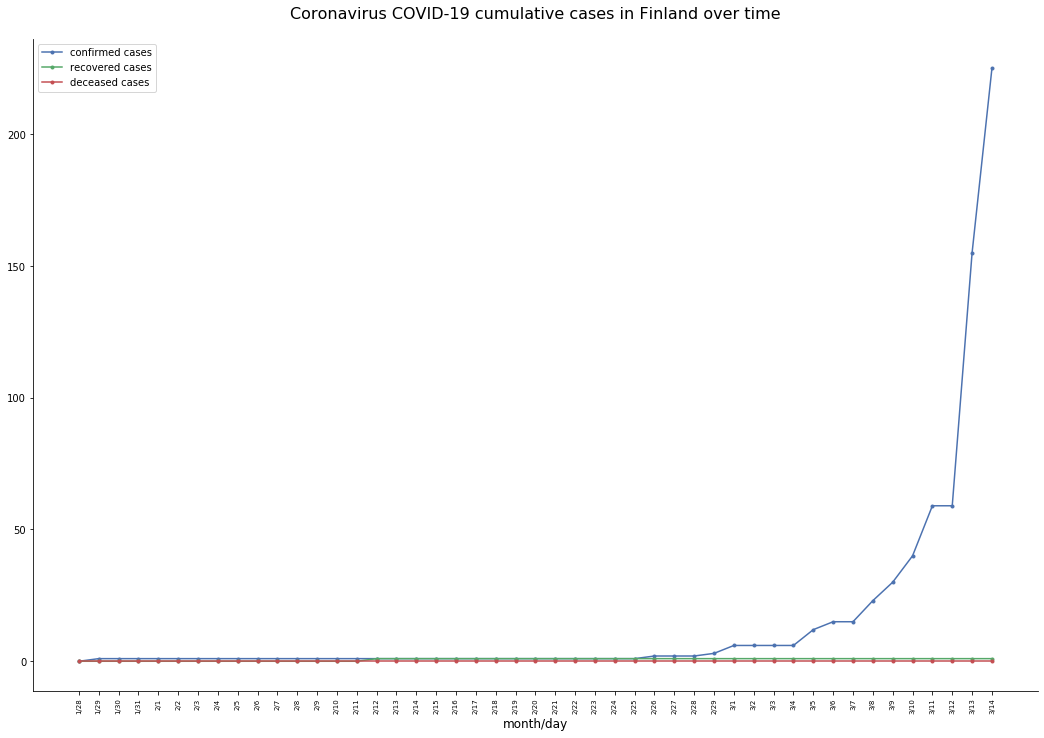

In [24]:
# Plotting daily cumulative cases in Finland
cust_line_plot((days_short, finland_confirmed_l, ".", 0, "confirmed cases"),
               (days_short, finland_recovered_l, ".", 2, "recovered cases"),
               (days_short, finland_deaths_l, ".", 3, "deceased cases"),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 cumulative cases in Finland over time",
               title_fs=16, title_offset=20,
               rem_borders=True,
               x_label="month/day", xlabel_fs=12,
               xvalues_fs=7,rot=90,
               y_label=None, ylabel_fs=12,
               legend=True)

**Description of the plot**

The blue curve represents the cumulative confirmed cases. Government decisions and people behavior can affect the way the blue curve looks like. The aim is to keep the curve not too steep in order not to saturate the capacity of the hospitals in the Country. However, it should be noted that the effects are not immediate due to the incubation period.

The green curve represents the recovered cases. The goal is trying to match the blue curve as close as possible, at a certain point in time.

The red curve represents the deceased cases and the goal is obviously to keep it as low as possible.

Finally, it shall not be forgotten that the actual cases might be higher than the confirmed cases.

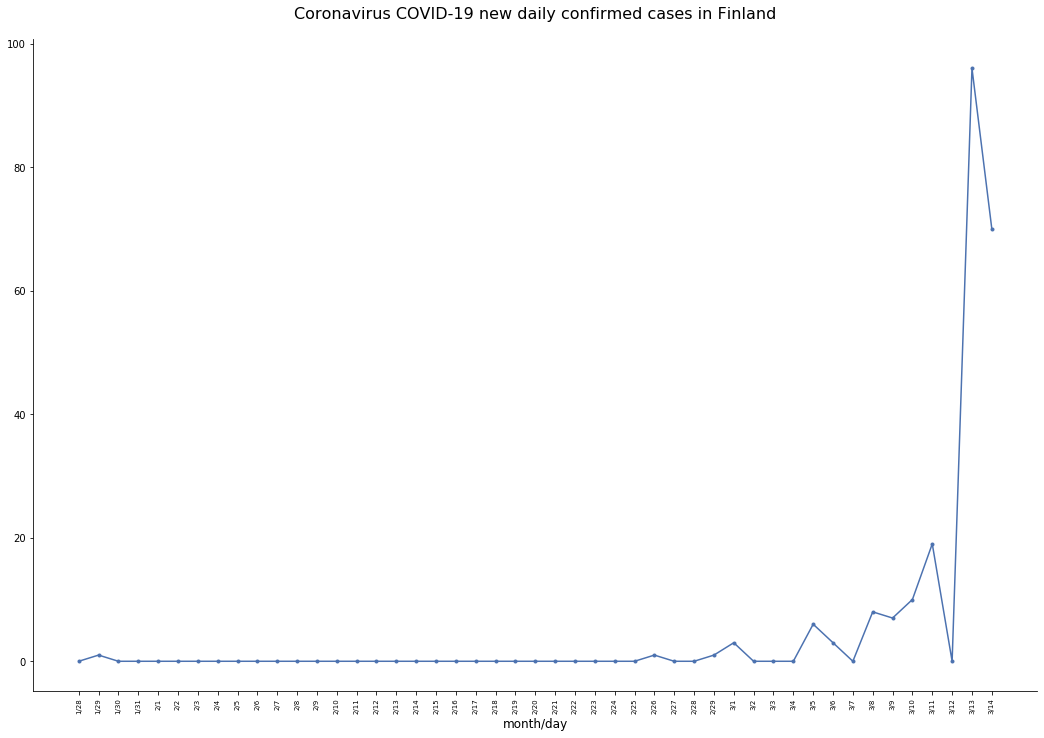

In [25]:
# Plotting new daily confirmed Coronavirus cases in Finland
cust_line_plot((days_short, finland_conf_incr, ".", 0, ""),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 new daily confirmed cases in Finland",
               title_fs=16, title_offset=20,
               rem_borders=True,
               x_label="month/day", xlabel_fs=12,
               xvalues_fs=7,rot=90,
               y_label=None, ylabel_fs=12,
               legend=False)

**Description of the plot**

This plot shows the new daily confirmed cases. Therefore, it shows the speed at which the virus is spreading.

### 6.2. Comparison with Other Scandinavian Countries <a name="6.2."></a>

**Description of the plots**

Even by shifting all the curves so that they start for each Country in the day of the first confirmed case, it appears that the curve is not steeper than the other 3 curves. This means the virus is not spreading faster.

Even though the virus started later in Finland, the first recovered case happened much earlier than the other Scandinavian Countries.

Currently, Finland is also the only one among those Countries with no deceased cases.

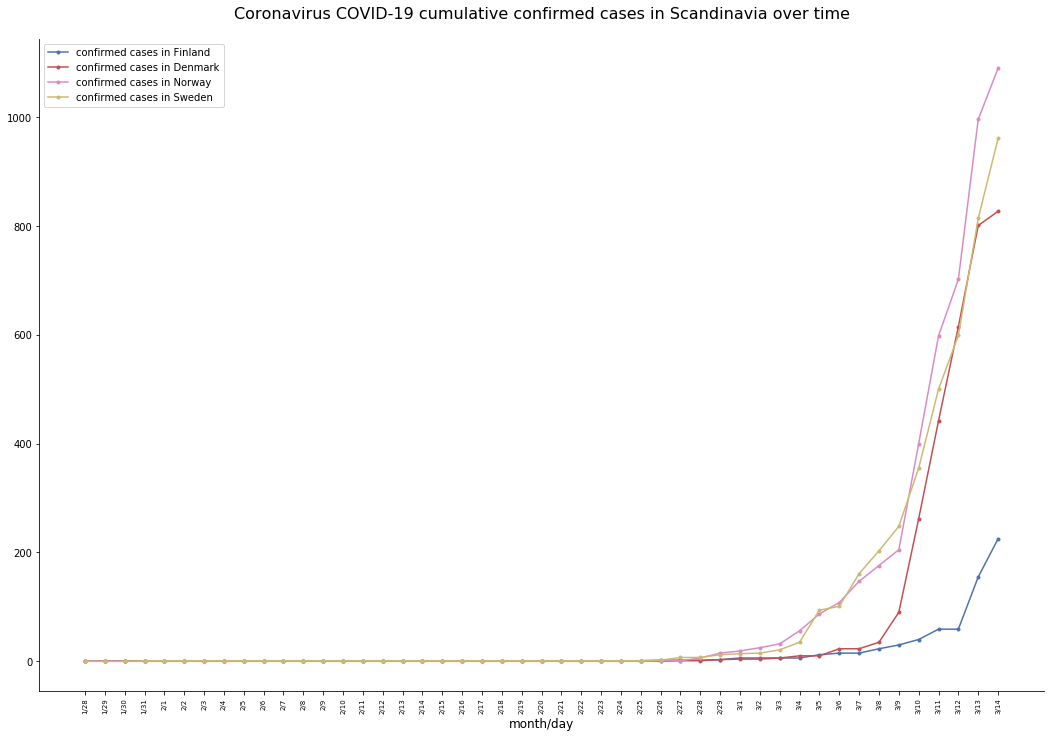

In [26]:
# Comparing cumulative confirmed cases over time in Scandinavia
cust_line_plot((days_short, finland_confirmed_l, ".", 0, "confirmed cases in Finland"),
               (days_short, denmark_confirmed, ".", 3, "confirmed cases in Denmark"),
               (days_short, norway_confirmed, ".", 6, "confirmed cases in Norway"),
               (days_short, sweden_confirmed, ".", 8, "confirmed cases in Sweden"),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 cumulative confirmed cases in Scandinavia over time",
               title_fs=16, title_offset=20,
               rem_borders=True,
               x_label="month/day", xlabel_fs=12,
               xvalues_fs=7,rot=90,
               y_label=None, ylabel_fs=12,
               legend=True)

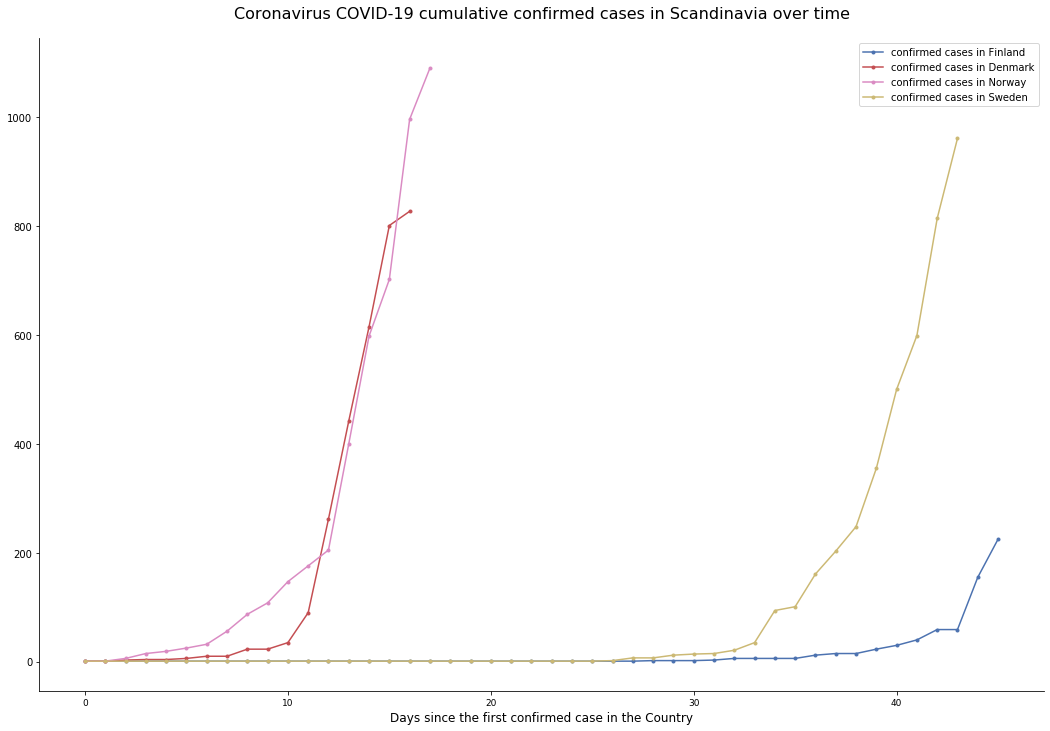

In [27]:
# Comparing cumulative confirmed cases over time in Scandinavia
# starting form the day of the first confirmed case
cust_line_plot((list(range(len(finland_confirmed_pos))), finland_confirmed_pos, ".", 0, "confirmed cases in Finland"),
               (list(range(len(denmark_confirmed_pos))), denmark_confirmed_pos, ".", 3, "confirmed cases in Denmark"),
               (list(range(len(norway_confirmed_pos))), norway_confirmed_pos, ".", 6, "confirmed cases in Norway"),
               (list(range(len(sweden_confirmed_pos))), sweden_confirmed_pos, ".", 8, "confirmed cases in Sweden"),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 cumulative confirmed cases in Scandinavia over time",
               title_fs=16, title_offset=20,
               rem_borders=True,
               x_label="Days since the first confirmed case in the Country", xlabel_fs=12,
               xvalues_fs=9,rot=0,
               y_label=None, ylabel_fs=12,
               legend=True)

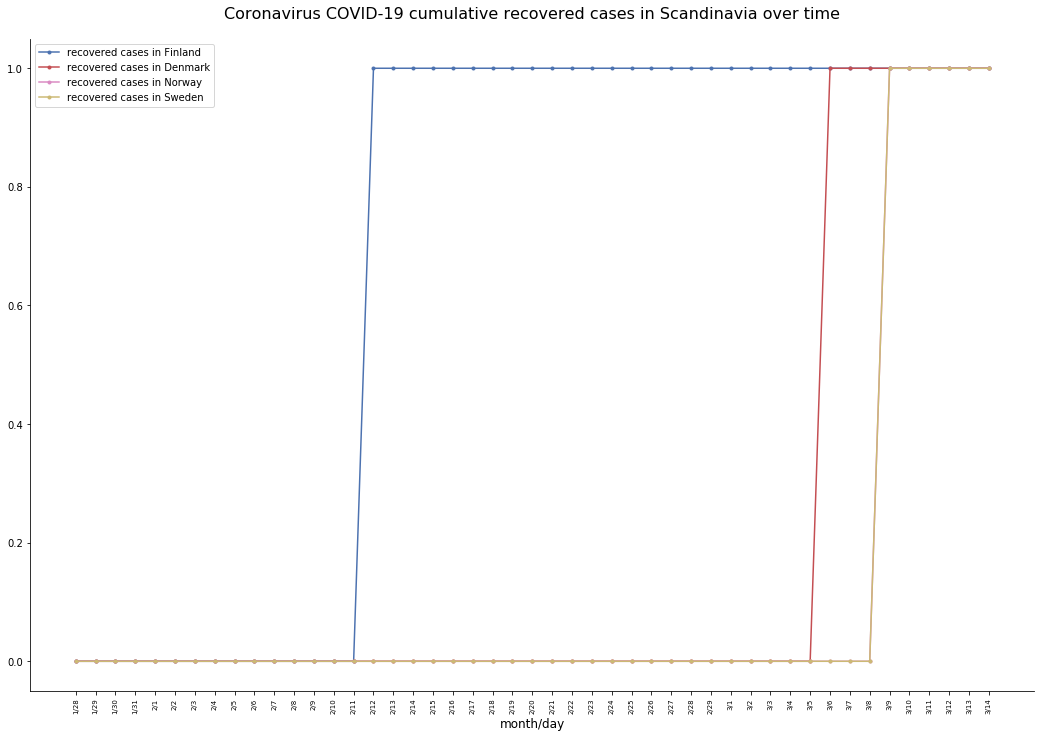

In [28]:
# Comparing cumulative recovered cases over time in Scandinavia
cust_line_plot((days_short, finland_recovered_l, ".", 0, "recovered cases in Finland"),
               (days_short, denmark_recovered, ".", 3, "recovered cases in Denmark"),
               (days_short, norway_recovered, ".", 6, "recovered cases in Norway"),
               (days_short, sweden_recovered, ".", 8, "recovered cases in Sweden"),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 cumulative recovered cases in Scandinavia over time",
               title_fs=16, title_offset=20,
               rem_borders=True,
               x_label="month/day", xlabel_fs=12,
               xvalues_fs=7,rot=90,
               y_label=None, ylabel_fs=12,
               legend=True)

NOTE: You do not see the curce for Norway since it is the same as the curve for Sweden.

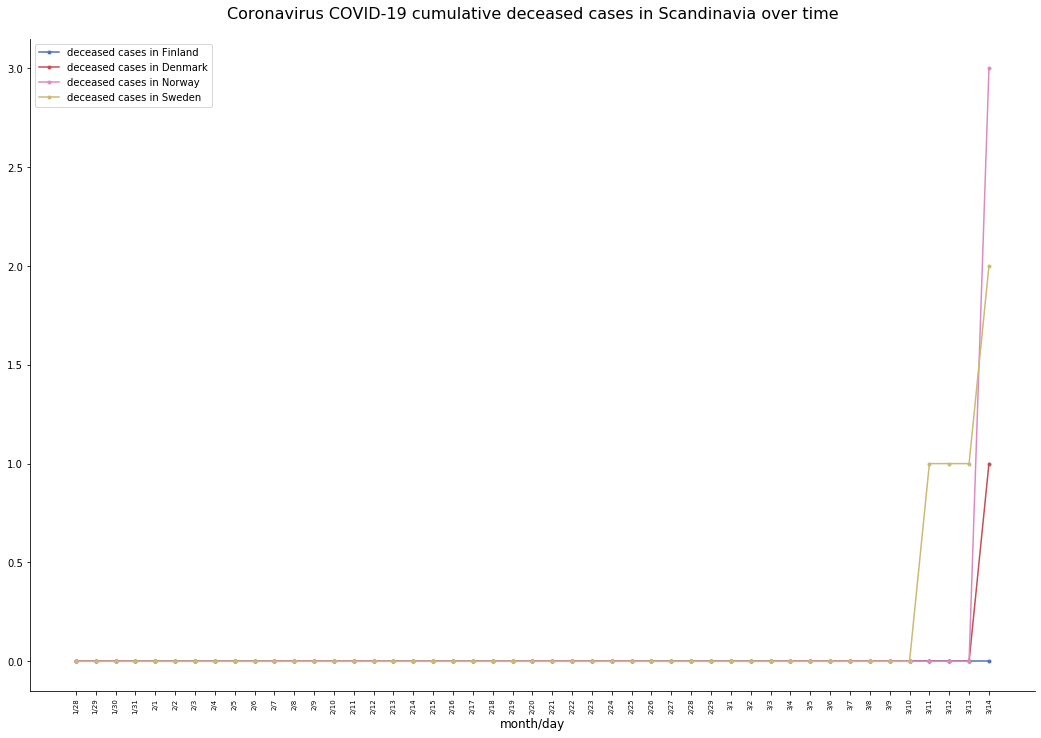

In [29]:
# Comparing cumulative deceased cases over time in Scandinavia
cust_line_plot((days_short, finland_deaths_l, ".", 0, "deceased cases in Finland"),
               (days_short, denmark_deceased, ".", 3, "deceased cases in Denmark"),
               (days_short, norway_deceased, ".", 6, "deceased cases in Norway"),
               (days_short, sweden_deceased, ".", 8, "deceased cases in Sweden"),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 cumulative deceased cases in Scandinavia over time",
               title_fs=16, title_offset=20,
               rem_borders=True,
               x_label="month/day", xlabel_fs=12,
               xvalues_fs=7,rot=90,
               y_label=None, ylabel_fs=12,
               legend=True)

### 6.3. Comparison with Italy and China<a name="6.3."></a>

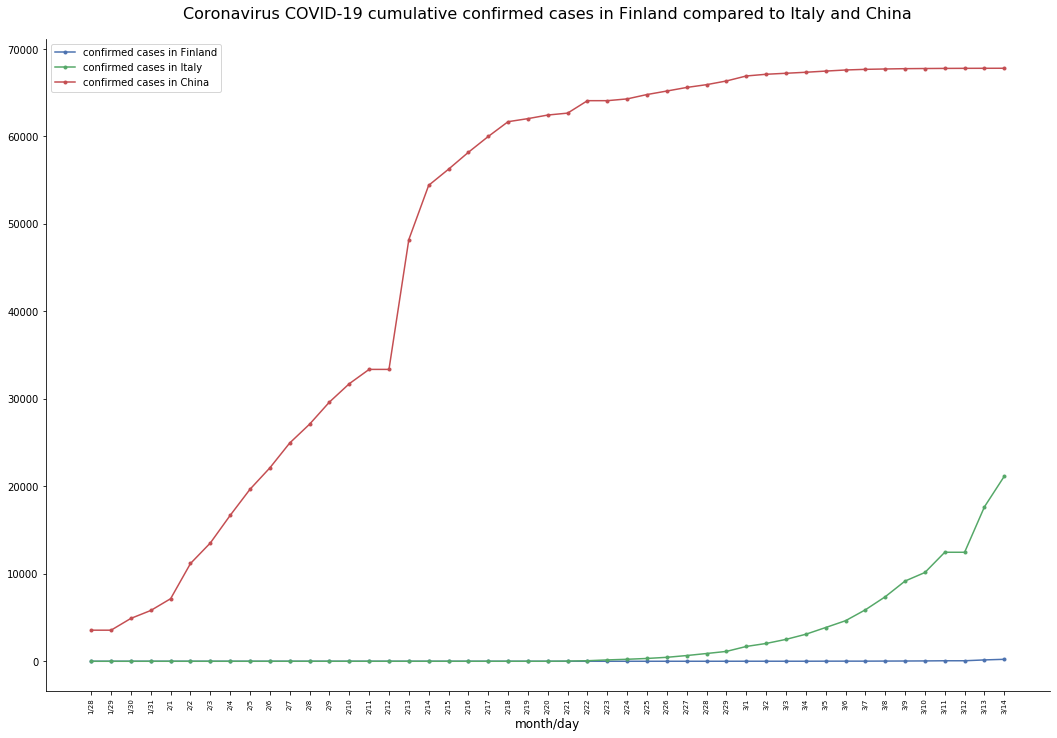

In [30]:
# Comparing cumulative confirmed cases over time for Finland, Italy and China
cust_line_plot((days_short, finland_confirmed_l, ".", 0, "confirmed cases in Finland"),
               (days_short, italy_confirmed, ".", 2, "confirmed cases in Italy"),
               (days_short, china_confirmed, ".", 3, "confirmed cases in China"),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 cumulative confirmed cases in Finland compared to Italy and China",
               title_fs=16, title_offset=20,
               rem_borders=True,
               x_label="month/day", xlabel_fs=12,
               xvalues_fs=7,rot=90,
               y_label=None, ylabel_fs=12,
               legend=True)

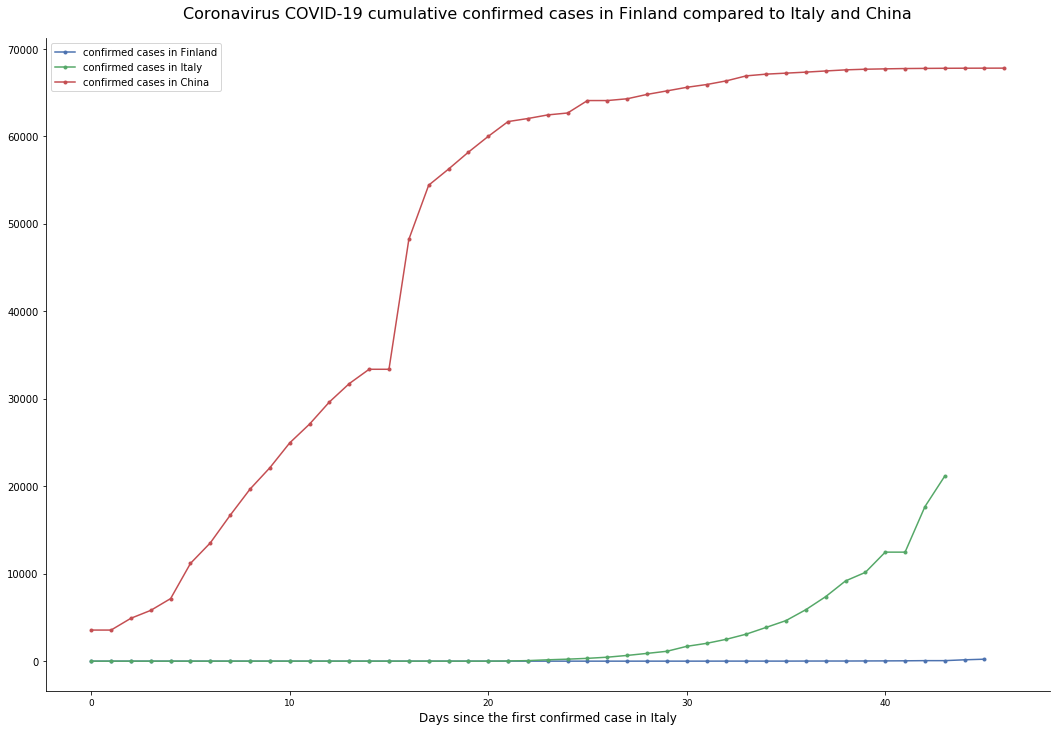

In [31]:
# Comparing cumulative confirmed cases over time for Finland, Italy and China
# starting form the day of the first confirmed case
cust_line_plot((list(range(len(finland_confirmed_pos))), finland_confirmed_pos, ".", 0, "confirmed cases in Finland"),
               (list(range(len(italy_confirmed_pos))), italy_confirmed_pos, ".", 2, "confirmed cases in Italy"),
               (list(range(len(china_confirmed_pos))), china_confirmed_pos, ".", 3, "confirmed cases in China"),
               figsize_w=18, figsize_h=12,
               title="Coronavirus COVID-19 cumulative confirmed cases in Finland compared to Italy and China",
               title_fs=16, title_offset=20,
               rem_borders=True,
               x_label="Days since the first confirmed case in Italy", xlabel_fs=12,
               xvalues_fs=9,rot=0,
               y_label=None, ylabel_fs=12,
               legend=True)

## 7. Conclusions <a name="7."></a>

The plots are shortly described in section 6.

Due to the need of daily updates, no additional comment is added here.

---
<sub>Used software:</sub><br>
<sub>- Jupyter Notebook server 6.0.1</sub><br>
<sub>- Python 3.6.8</sub><br>
<sub>- numpy 1.17.3</sub><br>
<sub>- pandas 0.25.2</sub><br>
<sub>- matplotlib 3.1.2</sub><br>
<sub>- seaborn 0.9.0</sub><br>
<sub>on top of Linux Ubuntu 18.04</sub><br>